## 4. Enriched EDA: Investigating the "Why"

### 4.1. Data Loading

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

db_user = 'root'
db_password = 'Kristine2004$'  
db_host = 'localhost'
db_name = 'banking_analysis'
connection_str = f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}'
engine = create_engine(connection_str)

In [19]:
sql_query = "SELECT * FROM vw_master_analysis;"

df_master = pd.read_sql(sql_query, engine)
    
op_path = '../data/master_banking_analysis.csv'
df_master.to_csv(op_path, index=False)
    
print(f"Master dataset created and saved to '{op_path}'")


Master dataset created and saved to '../data/master_banking_analysis.csv'


In [20]:
df_master.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   State                  35 non-null     object 
 1   Loss_2018_19           35 non-null     float64
 2   Loss_2019_20           35 non-null     float64
 3   YoY_Change_2019_20     35 non-null     float64
 4   Loss_2020_21           35 non-null     float64
 5   YoY_Change_2020_21     34 non-null     float64
 6   Loss_2021_22           35 non-null     float64
 7   YoY_Change_2021_22     35 non-null     float64
 8   Loss_2022_23           35 non-null     float64
 9   YoY_Change_2022_23     33 non-null     float64
 10  Loss_2023_24           35 non-null     float64
 11  YoY_Change_2023_24     31 non-null     float64
 12  Loss_2024_25           35 non-null     float64
 13  YoY_Change_2024_25     34 non-null     float64
 14  Cumulative_Loss        35 non-null     float64
 15  Volatili

### 4.2. Hypothesis Formulation
Before diving into visualization, let's formally state our hypotheses:
 1. **Economic Hypothesis:** Higher GSDP and GSDP growth are correlated with higher cumulative losses.
 2. **Demographic Hypothesis:** Higher population density, not just total population, contributes more to banking losses.
 3. **Infrastructure Hypothesis:** The sheer number of bank branches is less of a factor than the average loss per branch.
 4. **Socio-Economic Hypothesis:** Lower literacy rates may correlate with higher volatility in losses.

### 4.3. Feature Engineering

#### **Enriched Metrics:**
* **Loss per Capita**
Problem: Total loss is biased by state population
Solution: Normalize loss by population (Loss / Population) to compare risk intensity fairly

* **Loss per Branch**
Problem: Total loss is biased by the size of the banking network
Solution: Normalize loss by the number of branches (Loss / Branches) to measure average risk

* **Branches per Million People**
Problem: Raw branch count lacks context
Solution: Normalize branch count by population (Branches / Population) to measure banking density

In [21]:
df_master['Loss_per_Capita'] = (df_master['Cumulative_Loss'] * 10000000) / df_master['Population_Total']
df_master['Loss_per_Branch'] = (df_master['Cumulative_Loss'] * 10000000) / df_master['Bank_Branches_Total']
df_master['Branches_per_Million_People'] = (df_master['Bank_Branches_Total'] / df_master['Population_Total']) * 1000000

print("Metrics :")
print(df_master[['State', 'Loss_per_Capita', 'Loss_per_Branch', 'Branches_per_Million_People']])

Metrics :
                                       State  Loss_per_Capita  \
0                ANDAMAN AND NICOBAR ISLANDS        17.891221   
1                             ANDHRA PRADESH         4.562060   
2                          ARUNACHAL PRADESH         3.252087   
3                                      ASSAM        50.102289   
4                                      BIHAR         9.159260   
5                                 CHANDIGARH        13.842818   
6                               CHHATTISGARH        21.256132   
7   DADRA AND NAGAR HAVELI AND DAMAN AND DIU       138.047396   
8                                        GOA         9.667168   
9                                    GUJARAT        10.070059   
10                                   HARYANA       178.857546   
11                          HIMACHAL PRADESH       113.102181   
12                         JAMMU AND KASHMIR         7.257670   
13                                 JHARKHAND         5.983742   
14             

### 4.4. Relationships in the Data

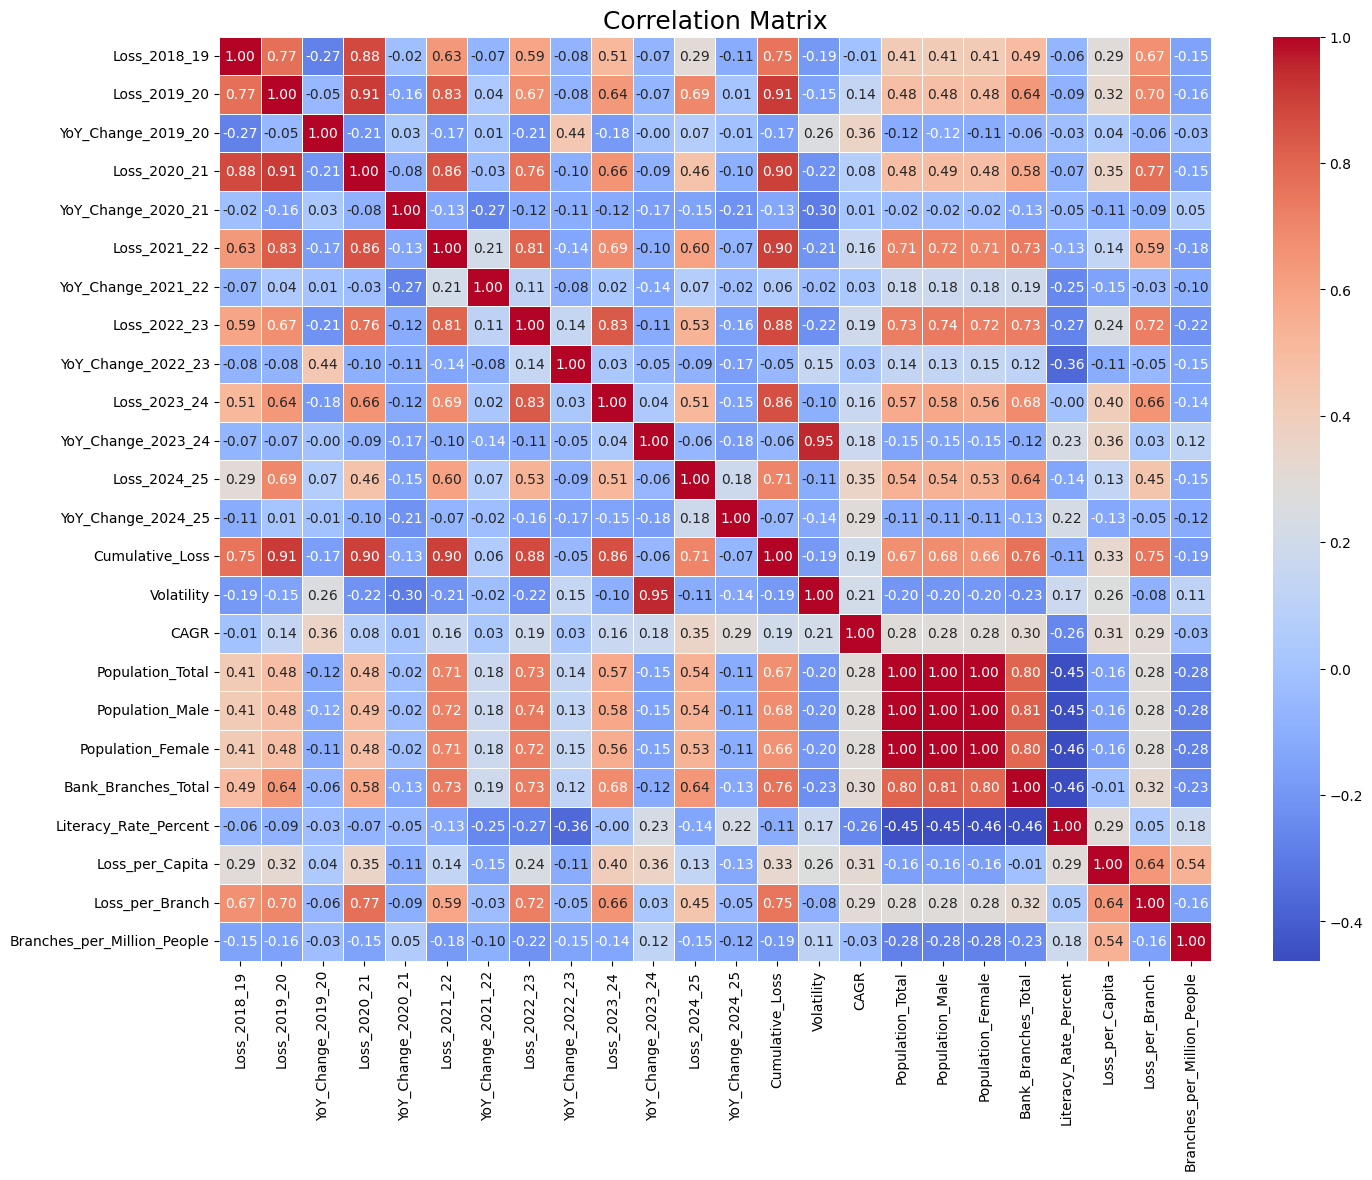

In [25]:
plt.figure(figsize=(16, 12))

numeric_cols = df_master.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

plt.title('Correlation Matrix', fontsize=18)
plt.show()

### **Key Insights from the Correlation Matrix**

*   **Strong Positive Correlations:**
    *   `Cumulative_Loss` shows a strong positive correlation with **`Population_Total` (0.67)** and **`Bank_Branches_Total` (0.66)**. 
    *   Larger states with more people tend to have higher loss.
    *   The strong correlation with **`Loss_per_Branch` (0.75)** states with high total losses also have a high average loss per bank branch. This is our first major clue that the problem might be related to operational intensity.

*   **Weak Correlations (Crucial Insights):**
    *   Weak correlation between `Cumulative_Loss` and **`Volatility` (-0.19)**. This indicates that the size of the loss and its unpredictability are two separate, distinct problems.
    *   Weak correlation between `Cumulative_Loss` and **`Loss_per_Capita` (0.33)**. Normalizing by population will provide a very different, more insightful insight, as  states with the highest total loss are not necessarily the ones with the most severe per-person impact.
    *   Weak correlation between `Cumulative_Loss` and **`Literacy_Rate_Percent` (-0.11)**. Same as Volatility.

### **4.4.1 Exploring Relationships: Weak Correlations**

### **Rel. 1: Cumulative Loss vs. Loss Per Capital**

C:\Users\KRISTINE\AppData\Local\Temp\ipykernel_26196\2968637905.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_by_capita, x='Loss_per_Capita', y='State', palette='viridis')


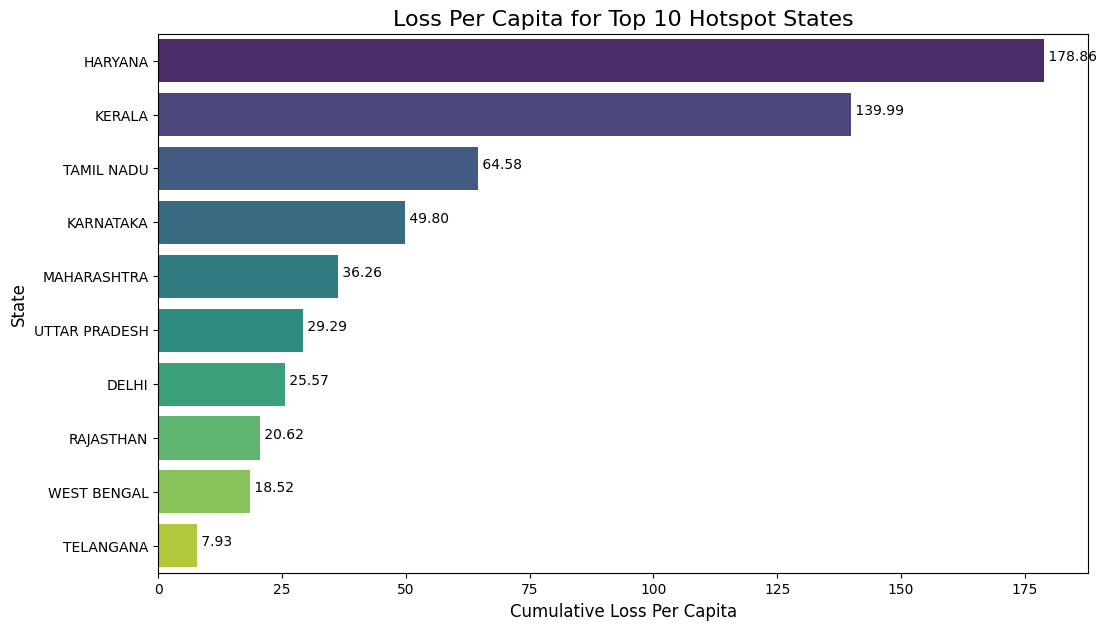

In [30]:
plt.figure(figsize=(12, 7))

sorted_by_capita = top_10_states.sort_values('Loss_per_Capita', ascending=False)

sns.barplot(data=sorted_by_capita, x='Loss_per_Capita', y='State', palette='viridis')

plt.title('Loss Per Capita for Top 10 Hotspot States', fontsize=16)
plt.xlabel('Cumulative Loss Per Capita', fontsize=12)
plt.ylabel('State', fontsize=12)

for ind, val in enumerate(sorted_by_capita['Loss_per_Capita']):
    plt.text(val, ind, f' {val:,.2f}')

plt.show()


### **Insights from the Per-Capita Analysis**

Comparing the `Cumulative_Loss` with the `Loss_per_Capita` :

*   **New Top Hotspot:** **Haryana** is the new #1 hotspot by a significant margin. Its per-capita loss of ₹178.86 is dramatically higher than anyone else's, revealing a problem of extreme intensity.

*   **Maharashtra's Big Change:**  **Maharashtra**, #1 drops to a #5 position.  its high ranking was largely because of its large population. While still a significant problem, it's not the most intense problem on a per-citizen basis.

*   **Hidden Risk Revealed:** **Kerala** jumps from 6th place in total loss to 2nd in per-capita loss, showing its a critical, previously underestimated hotspot.

This analysis proves that normalizing by population provides a more accurate measure of risk severity and helps prioritize resources more effectively.

**New Hotspot Tiers:**
*   Tier 1 (Extreme Intensity): Haryana (₹178.86) and Kerala (₹139.99) are in a league of their own.
*   Tier 2 (High Intensity): Tamil Nadu (₹64.58) and Karnataka (₹49.80) form a second distinct group.
*   Tier 3 (Moderate Intensity): The remaining states, including the original #1 Maharashtra, fall into a lower tier of per-capita risk.

**Finding hotspot is a multi dimensional approach, these 2 metrics answer these 2 qns**
*   How big is the problem? (Cumulative_Loss)
*   How severe is the problem? (Loss_per_Capita)

Now we furthur delve into toehrs

### **Rel. 2: Cumulative Loss vs. Volatlity**

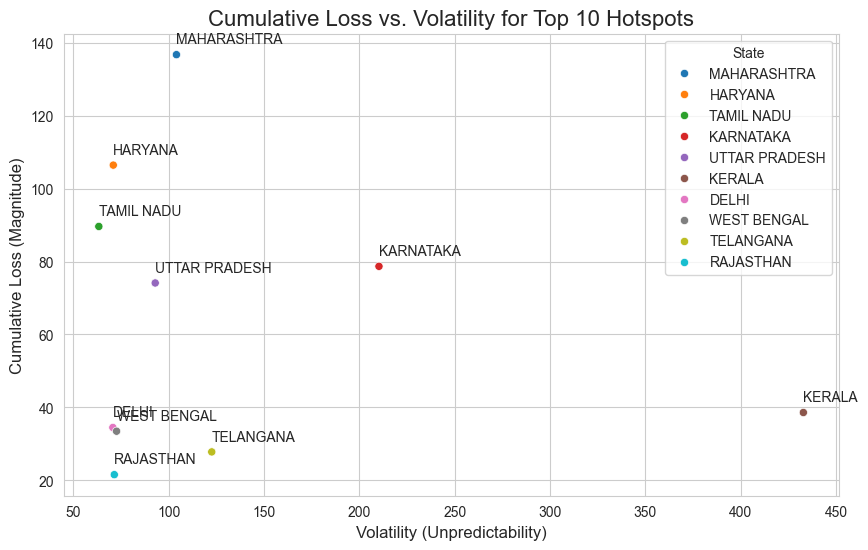

In [43]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=top_10_states, x='Volatility', y='Cumulative_Loss', hue='State', s=35)

for i, row in top_10_states.iterrows():
    plt.text(row['Volatility'], row['Cumulative_Loss'] + 3, row['State'])

plt.title('Cumulative Loss vs. Volatility for Top 10 Hotspots', fontsize=16)
plt.xlabel('Volatility (Unpredictability)', fontsize=12)
plt.ylabel('Cumulative Loss (Magnitude)', fontsize=12)
plt.grid(True)
plt.show()

### **Key Insights from the Volatility vs. Loss Plot**

there is no significant linear relationship between the size of the loss (magnitude) and its unpredictability (volatility). They are independent problems.

*   **Chronic Problems (High Loss, Low Volatility):** Maharashtra and Haryana have large but predictable losses.
*   **Danger Zone (High Loss, High Volatility):** Karnataka is at the most critical risk,  both large and unpredictable.
*   **The Ticking Time Bomb (Low Loss, High Volatility):** Kerala shows extreme unpredictability, making it a major hidden risk despite its moderate total loss.
*   **Managed Risk (Low Loss, Low Volatility):** States like Delhi, West Bengal, Rajasthan, Telangana have smaller, more stable loss patterns.

### **Rel. 2: Cumulative Loss vs. Literacy Rate**

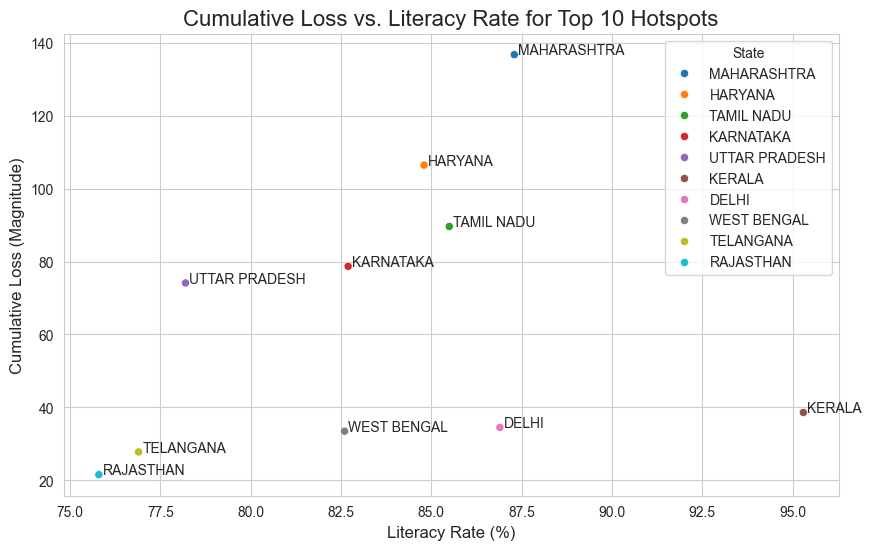

In [47]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=top_10_states, x='Literacy_Rate_Percent', y='Cumulative_Loss', hue='State', s=35)

for i, row in top_10_states.iterrows():
    plt.text(row['Literacy_Rate_Percent'] + 0.1, row['Cumulative_Loss'], row['State'])

plt.title('Cumulative Loss vs. Literacy Rate for Top 10 Hotspots', fontsize=16)
plt.xlabel('Literacy Rate (%)', fontsize=12)
plt.ylabel('Cumulative Loss (Magnitude)', fontsize=12)
plt.grid(True)
plt.show()

*   A correlation coefficient of -0.11 indicates there is no meaningful linear relationship whatsoever. The scatter plot confirms this. The points are randomly scattered, there is no pattern.
*   Conclusion remains the same, but with higher confidence: Literacy rate is not a significant factor in explaining the magnitude of cumulative banking losses among these hotspot states.

### **Rel. 3: Cumulative Loss vs. Banking Density**


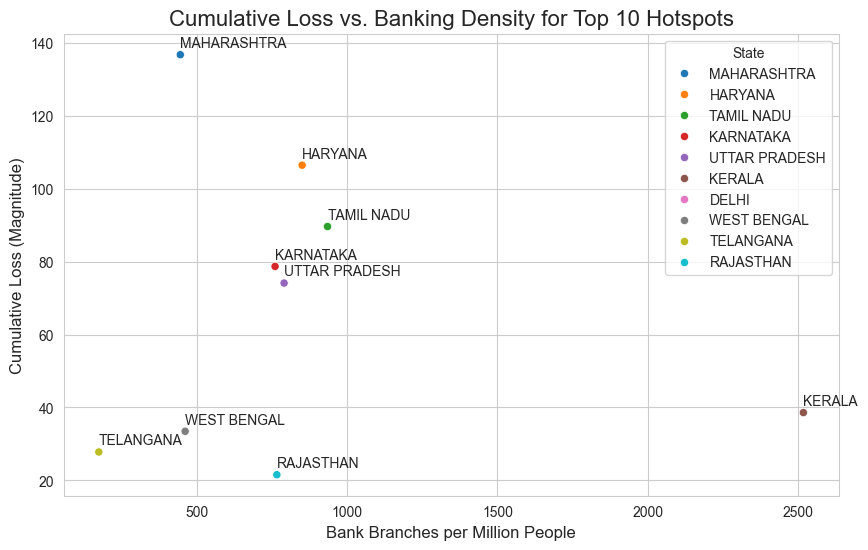

In [48]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=top_10_states, x='Branches_per_Million_People', y='Cumulative_Loss', hue='State', s=35)

for i, row in top_10_states.iterrows():
    plt.text(row['Branches_per_Million_People'], row['Cumulative_Loss'] + 2, row['State'])

plt.title('Cumulative Loss vs. Banking Density for Top 10 Hotspots', fontsize=16)
plt.xlabel('Bank Branches per Million People', fontsize=12)
plt.ylabel('Cumulative Loss (Magnitude)', fontsize=12)
plt.grid(True)
plt.show()

### Insights from Banking Density vs. Loss Plot

*   **No Consistent Trend for Most States:** Majority top hotspots, there is no **clear relationship** between banking density and cumulative loss. 

*   **Outlier:** The weak negative correlation seen in the heatmap is likely caused by **Kerala**. It has an exceptionally high banking density (over 2500 branches per million) and a moderate cumulative loss.

*   **Conclusion:** Banking density is **not a primary driver** of cumulative loss for most states.

### **4.4.2 Exploring Relationsips: Strong Postive Corellations**

### **Rel. 1: Cumulative Loss vs. Total Population**


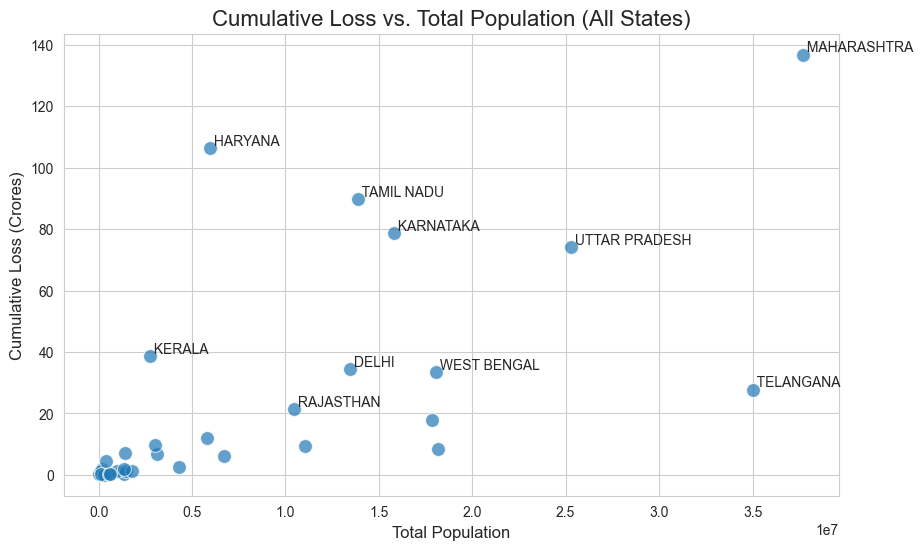

In [51]:
plt.figure(figsize=(10, 6))

# Use the full df_master to visualize the overall trend
sns.scatterplot(data=df_master, x='Population_Total', y='Cumulative_Loss', s=100, alpha=0.7)

for i, row in df_master.nlargest(10, 'Cumulative_Loss').iterrows():
    plt.text(row['Population_Total'], row['Cumulative_Loss'], ' ' + row['State'], va='bottom')

plt.title('Cumulative Loss vs. Total Population (All States)', fontsize=16)
plt.xlabel('Total Population', fontsize=12)
plt.ylabel('Cumulative Loss (Crores)', fontsize=12)
plt.grid(True)
plt.show()

### Insights from Population vs. Loss Plot
*   **General Trend Confirmed:** The plot shows a clear **positive correlation**, confirming that states with larger populations tend to have higher absolute cumulative losses.

*   **Haryana is a Key Outlier:** Haryana shows a disproportionately **high cumulative loss** for its relatively **small population**, sitting far above the general trend line. This reinforces the finding that it has an exceptionally high risk intensity.

*   **"Below Trend" States:** States like Telangana and Kerala exhibit **lower cumulative losses** than would be expected for their population size, suggesting better performance or different risk dynamics.


### **Rel. 2: Cumulative Loss vs. Total Bank Branches**

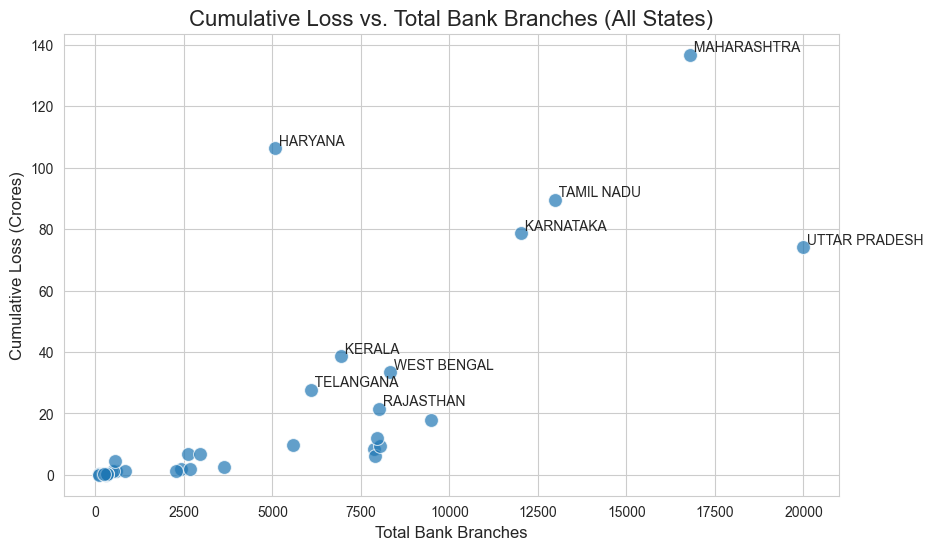

In [52]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_master, x='Bank_Branches_Total', y='Cumulative_Loss', s=100, alpha=0.7)

plt.title('Cumulative Loss vs. Total Bank Branches (All States)', fontsize=16)
plt.xlabel('Total Bank Branches', fontsize=12)
plt.ylabel('Cumulative Loss (Crores)', fontsize=12)
plt.grid(True)

for i, row in df_master.nlargest(10, 'Cumulative_Loss').iterrows():
    plt.text(row['Bank_Branches_Total'], row['Cumulative_Loss'], ' ' + row['State'], va='bottom')

plt.show()

### Insights from Bank Branches vs. Loss Plot

*   **Generalve Trend Confirmed:** The plot shows a **strong positive correlation**. Generally, states with a larger network of bank branches experience higher absolute cumulative losses.

*   **Haryana and Maharashtra as Outliers:** Both states sit significantly above the general trend line, indicating their **cumulative losses are disproportionately high** for their number of bank branches.

### **Rel. 3: Cumulative Loss vs. Loss per Branch**

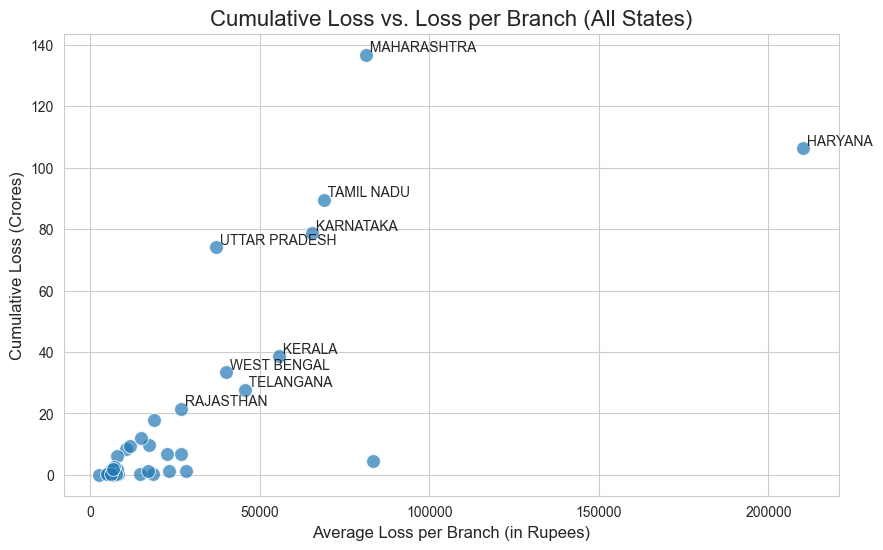

In [53]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_master, x='Loss_per_Branch', y='Cumulative_Loss', s=100, alpha=0.7)

plt.title('Cumulative Loss vs. Loss per Branch (All States)', fontsize=16)
plt.xlabel('Average Loss per Branch (in Rupees)', fontsize=12)
plt.ylabel('Cumulative Loss (Crores)', fontsize=12)
plt.grid(True)

for i, row in df_master.nlargest(10, 'Cumulative_Loss').iterrows():
    plt.text(row['Loss_per_Branch'], row['Cumulative_Loss'], ' ' + row['State'], va='bottom')

plt.show()

### Key Insights from the Loss vs. Loss per Branch Plot

*   **Strong Linear Relationship:** This plot shows very strong positive correlation (+0.75). For most states, a higher total loss is directly and predictably associated with a higher average loss per branch.

*   **Haryana is an Extreme Outlier:** Haryana's average loss per branch is more than double any other hotspot state. This is a major, severe risk problem.


### 4.5. Looking at GSDP
*   In our initial heatmap, the GSDP columns were missed due to a data formatting issue. We will now correct this and perform a focused analysis to test our economic hypothesis: "Is higher economic activity correlated with higher banking losses?"

In [55]:

gsdp_cols = [col for col in df_master.columns if 'GSDP_' in col]

for col in gsdp_cols:
    df_master[col] = df_master[col].astype(str)
    df_master[col] = df_master[col].str.replace(r'[\,,\[a-zA-Z\]]', '', regex=True)
    df_master[col] = pd.to_numeric(df_master[col], errors='coerce')

print("GSDP columns  converted to numeric type.")
print(df_master[gsdp_cols].info())

GSDP columns  converted to numeric type.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GSDP_2018-19  35 non-null     float64
 1   GSDP_2019-20  35 non-null     float64
 2   GSDP_2020-21  35 non-null     float64
 3   GSDP_2021-22  35 non-null     float64
 4   GSDP_2022-23  35 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB
None


### Trend Analysis: Yearly Loss vs. Yearly GSDP
